# Import and functions

In [1]:
import os
import pandas as pd
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns


In [4]:
def convert_pdf_to_txt(path, maxpages=0):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text


def plot_as_word_cloud(labels, filenames_short):
    wordclouds=[]
    for label in set(labels):
        label_files = [x[1] for x in zip(labels,filenames_short) if x[0]==label]
        wordcloud = WordCloud(background_color="white", max_font_size=40).generate(" ".join(label_files))
        wordclouds.append(wordcloud.to_image())

    n = int(np.ceil(np.sqrt(len(wordclouds))))
    plt.rcParams['figure.figsize'] = [10,8]
    plt.subplots_adjust(wspace=.02, hspace=.02)
    for i, wordcloud in enumerate(wordclouds):
        _ = plt.subplot(n, n, i+1)
        _ = plt.imshow(wordclouds[i])
        _ = plt.axis('off')
        
        
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

# Extract features

In [8]:
root_dir = r"pdf_files"
texts = []
files = []

vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1, 1), max_features=1024)

for filename in glob.iglob(os.path.join(root_dir, "**"), recursive=True):
    if filename.endswith(".pdf"):
#         print(filename)
        texts.append(convert_pdf_to_txt(filename, maxpages=1))
        files.append(filename)

X = vectorizer.fit_transform(texts)
with open('data.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump({"data": X, "vectorizer": vectorizer}, file)
  

# Load features and cluster

In [2]:
with open('data.pkl', 'rb') as file:
    data = pickle.load(file)
X, vectorizer = data['data'], data['vectorizer']


In [ ]:
# plt.figure(figsize=(12,10))
# df = pd.DataFrame(data = X.toarray())
# cor = df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

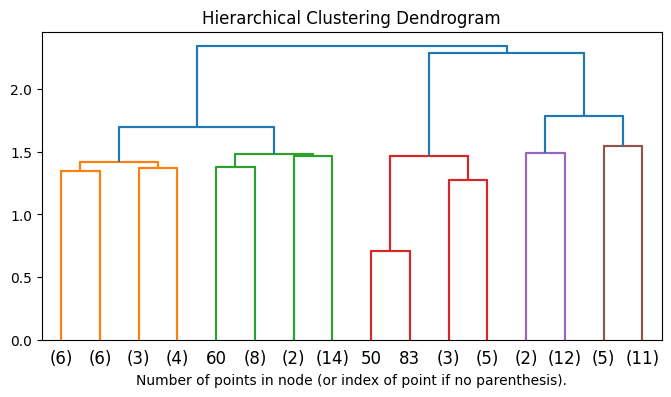

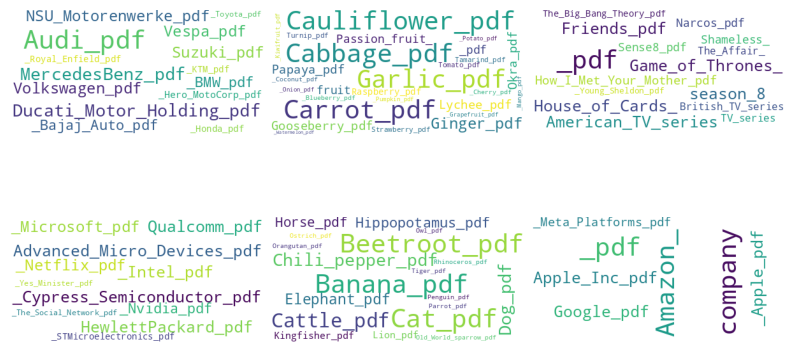

In [19]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
Y = clustering.fit(X.toarray())
plt.rcParams['figure.figsize'] = [8, 4]
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level", p=3)
plot_dendrogram(clustering, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# clustering = DBSCAN(eps=3, min_samples=1)
# clustering = AgglomerativeClustering(affinity='cosine', linkage='single')
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
Y = clustering.fit(X.toarray())
labels = Y.labels_
filenames_short = [f.split("wiki")[-1].replace("-", "").replace(".", "_") for f in files]
# Save and visualize
df = pd.DataFrame(list(zip(Y.labels_, files)), columns=['label', 'filename'])
plot_as_word_cloud(labels, filenames_short)
df.to_csv("results.csv")


In [16]:
# clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=None, distance_threshold=0)
# Y = clustering.fit(X.toarray())
# plt.rcParams['figure.figsize'] = [8, 4]
# plt.title("Hierarchical Clustering Dendrogram")
# plot_dendrogram(clustering, truncate_mode="level", p=3)
# plot_dendrogram(clustering, truncate_mode="level", p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

# # clustering = DBSCAN(eps=3, min_samples=1)
# # clustering = AgglomerativeClustering(affinity='cosine', linkage='single')
# clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=None, distance_threshold=14)
# Y = clustering.fit(X.toarray())
# labels = Y.labels_
# filenames_short = [f.split("wiki")[-1].replace("-", "").replace(".", "_") for f in files]
# # Save and visualize
# df = pd.DataFrame(list(zip(Y.labels_, files)), columns=['label', 'filename'])
# plot_as_word_cloud(labels, filenames_short)
# df.to_csv("results.csv")


# Final model

In [17]:
with open('clustering.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump({"model": clustering}, file)
  

In [20]:
labels

array([3, 5, 5, 0, 4, 4, 1, 1, 4, 4, 1, 4, 4, 0, 4, 2, 2, 1, 1, 5, 1, 3,
       4, 4, 2, 2, 4, 4, 1, 0, 2, 0, 1, 4, 4, 4, 4, 1, 4, 1, 4, 3, 1, 4,
       2, 2, 1, 0, 1, 2, 2, 4, 1, 1, 0, 0, 5, 0, 1, 0, 1, 1, 3, 1, 0, 0,
       3, 1, 0, 1, 5, 3, 3, 3, 1, 1, 1, 0, 3, 3, 0, 1, 3, 2], dtype=int64)